In [1]:
# Principal Components Analysis
import pandas as pd

# Read data from website url
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)
print(type(df_wine))
#print(df_wine.describe())


<class 'pandas.core.frame.DataFrame'>


In [2]:
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df_wine.iloc[:,1:].values, df_wine.iloc[:,0].values # downcast from pd.DataFrame to np.ndarray
print(type(X))

<class 'numpy.ndarray'>


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   test_size = 0.3,
                                                   random_state = 0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train) # .fit() gets mu and std, then transform to z-score
X_test_std  = sc.transform(X_test)      # transform using train's mu and std, to z-score

In [4]:
import matplotlib.pylab as plt
plt.hist(X_test_std) # check if it looks reasonable
plt.show()

<Figure size 640x480 with 1 Axes>

In [5]:
# Eigenvalue and eigenvectors
import numpy as np
cov_mat = np.cov(X_train_std.T) # do forget that np.cov() need matrix in certain format
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\n Eigenvalues \n %s' % eigen_vals )


 Eigenvalues 
 [4.8923083  2.46635032 1.42809973 1.01233462 0.84906459 0.60181514
 0.52251546 0.08414846 0.33051429 0.29595018 0.16831254 0.21432212
 0.2399553 ]


In [6]:
# compute variance explained ratio
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

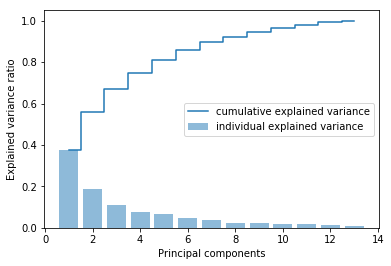

In [7]:
import matplotlib.pyplot as plt
plt.bar(range(1,14), var_exp, alpha = 0.5, align = 'center',
        label = 'individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid', 
        label = 'cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

In [8]:
# Feature transformation
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i])
              for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True)

In [9]:
W = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print(W.shape)
print('Matrix W with columns as EigenVectors: \n', W)

(13, 2)
Matrix W with columns as EigenVectors: 
 [[ 0.14669811  0.50417079]
 [-0.24224554  0.24216889]
 [-0.02993442  0.28698484]
 [-0.25519002 -0.06468718]
 [ 0.12079772  0.22995385]
 [ 0.38934455  0.09363991]
 [ 0.42326486  0.01088622]
 [-0.30634956  0.01870216]
 [ 0.30572219  0.03040352]
 [-0.09869191  0.54527081]
 [ 0.30032535 -0.27924322]
 [ 0.36821154 -0.174365  ]
 [ 0.29259713  0.36315461]]


In [10]:
X_train_std[0].dot(W)

array([2.59891628, 0.00484089])

In [11]:
X_train_pca = X_train_std.dot(W)


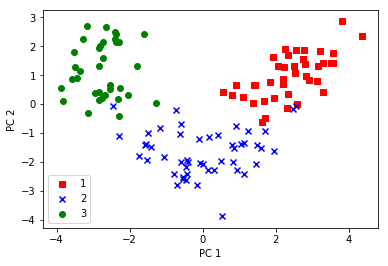

In [12]:
colors = ['r','b','g']
markers = ['s','x','o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l,0],
                X_train_pca[y_train==l,1],
                c=c, label = l, marker = m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

In [13]:
np.unique(y_train)

array([1, 2, 3], dtype=int64)

In [14]:
# Supervised Data Compression via Linear Discriminant Analysis (just the basics)
# 1. Standardize d-dim dataset (d-features)
# 2. For each class c, compute d-dim mean vector
# 3. Construct between-class (SB) and within-class scatter matrix (SW)
# 4. Compute eigenvectors and eigenvalues of matrix (SW^(-1))/(SB)
# 5. Choose k eigenvectors  for largest k eigenvalues, dxk transformation matrix W (eigen vectors are columns)
# 6. Project samples onto the new feature space using W

np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(
        X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' %(label, mean_vecs[label-1]))
    

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



In [15]:
# use mean vectors to compute SW (within-class scatter matrix)
d = 13 # nos of features
S_W = np.zeros((d,d))
for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d,1), mv.reshape(d,1)
        class_scatter += (row-mv).dot((row-mv).T)
    S_W += class_scatter
    
print('Within-class scatter matrix: %s x %s' % (S_W.shape[0], S_W.shape[1])) 

Within-class scatter matrix: 13 x 13


In [16]:
print('Class label distribution: %s' % np.bincount(y_train)[1:])

Class label distribution: [40 49 35]


In [17]:
# use mean vectors to compute SW (within-class scatter matrix)
d = 13 # nos of features
S_W = np.zeros((d,d))
for label, mv in zip(range(1,4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
    
print('Scaled within-class scatter matrix: %s x %s' % (S_W.shape[0], S_W.shape[1])) 

Scaled within-class scatter matrix: 13 x 13


In [18]:
# SB between-class scatter matrix
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d,d))
for i, mean_vec in enumerate(mean_vecs):
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(d,1)
    mean_overall = mean_overall.reshape(d,1)
    S_B += n*(mean_vec - mean_overall).dot((mean_vec-mean_overall).T)
    
print('Between-class scatter matrix: %s x %s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13 x 13


In [19]:
!pip install pandas_datareader


In [20]:
##  using PCA for Stock Prices
# 1. Get historical stock price data from yahoo for Dow Jones 30 constituents, 
#    first install pandas_datareader 
#    > pip install pandas_datareader or > conda install pandas_datareader
#    Or go to Anaconda-Navigator/Environment/Not Installed/pandas_datareader
# 2. Compute the cov matrix from scaled data
# 3. Use np.linalg.eig(cov_mat)
# 4. Compute and examine eigen_vectors and eigen_values
#
# More challenging problems
# 5. Try to identify the 1st principle component, what do you think it is?
# 6. Predict next days returns for 'AAPL' using all your data and all your algos
#    use 10-fold cross validation
# 7. Would you trade this ML Stock prediction model? 
#   Why or why not? Did you make any inadvertent 'cheats'? 

In [21]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def get_prices(ticks, st, ed):
# This function gets Adjusted Closing prices from Yahoo Finance
# returns a DataFrame. Inputs are ticks (list of tickers), st (start date), ed (end date)
    for idx, ticker in enumerate(ticks):
        print(ticker)
        f = web.DataReader(ticker, 'yahoo', st, ed)['Adj Close']
        f.name = ticker
        if idx==0:
            df = f
        else:
            df = pd.concat([df, f], axis=1)
        return df


In [22]:
#tickers = [['AAPL','BA','CAT', 'SPY']]

### Need to uncomment this for HWK#2 ###
tickers = [['MMM','AXP','AAPL','BA','CAT','CVX','CSCO','KO','DIS',
          'XOM','GE','GS','HD','IBM','INTC','JNJ','JPM','MCD','MRK','MSFT',
          'NKE','PFE','PG','TRV','UTX','UNH','VZ','V','WMT', 'SPY']]

start = dt.datetime(2010, 1, 1)
end   = dt.datetime.today()

df = get_prices(tickers, start, end)
df = df.pct_change().dropna()

X = df

# scale X's
sc = StandardScaler() # x(i)_new = (x(i) - mean(x))/std(x)
#sc = MinMaxScaler()   # x(i)_new = (x(i) - min(x))/(max(x)-min(x))
sc.fit(X)
X_std = sc.transform(X)

#print(X_std.shape)
#print(X_std.std(axis=0)
#print(X_std.mean(axis=0))

cov_mat = np.cov(X_std.T) # careful here need to transpose "X" 
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenValues \n%s' % eigen_vals)


['MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'XOM', 'GE', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UTX', 'UNH', 'VZ', 'V', 'WMT', 'SPY']

EigenValues 
[14.0023  1.4938  1.0834  0.0339  0.9232  0.86    0.1926  0.1907  0.7528
  0.2921  0.3059  0.7096  0.6675  0.6593  0.6328  0.6199  0.5923  0.5778
  0.5644  0.363   0.3734  0.4013  0.4085  0.417   0.4436  0.461   0.476
  0.5187  0.4903  0.5057]


C:\Users\cheng\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  del sys.path[0]


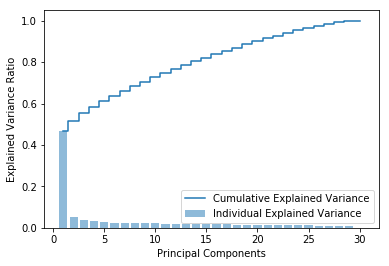

In [23]:
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1,len(var_exp)+1), var_exp, alpha = 0.5, align = 'center',
        label = 'Individual Explained Variance')
plt.step(range(1,len(var_exp)+1), cum_var_exp, where='mid',
        label = 'Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.show()

In [24]:
# Sort eigenpairs in descending order, construct a projection matrix from the
# selected eigenvectros, use projection matrix (W) to transform the data into lower-dimentional subspace

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) 
              for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True)

W = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print(W.shape)

f1 = X.dot(W[:,0])
f2 = X.dot(W[:,1])

(30, 2)


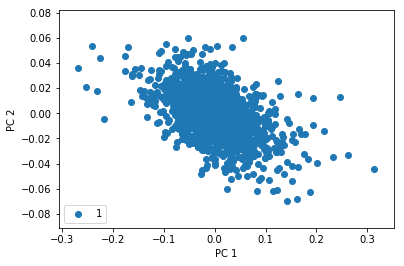

In [25]:
# Use Eigen Vectors and project original X onto two principal components PC1, PC2
X_pca = X.dot(W)

plt.scatter(X_pca[0],X_pca[1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

## More challenging problems

In [26]:
# Helpful ideas for figuring what is the 1st PC
# You will need to get data for 'SPY' returns 
combo = pd.concat([df['SPY'], X_pca], axis=1)

print('Cross Correlation')
print(np.corrcoef(combo.T))

Cross Correlation
[[ 1.     -0.9808  0.4949]
 [-0.9808  1.     -0.472 ]
 [ 0.4949 -0.472   1.    ]]


In [27]:
# 6. Predict next days returns for 'AAPL' using all your data and all your algos
#    use 10-fold cross validation
# 7. Would you trade this ML Stock prediction model? 
#   Why or why not? Did you make any inadvertent 'cheats'? 
y =  df['AAPL'].shift(-1) # next day's returns
y = y.fillna(0)
y = np.where(y > 0, 1, -1)

X = df.values

print(type(X),type(y))
print(X.shape, y.shape)


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2329, 30) (2329,)


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#import warnings
#warnings.filterwarnings("ignore")

from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score

names = ["Perceptron",
         "LogisticRegression",
         "Linear SVM", 
         "Decision Tree", 
         "Random Forest", 
         "RBF SVM",          
         "Neural Net", 
         "Naive Bayes",  
         "Nearest Neighbors"] 

classifiers = [
    Perceptron(),
    LogisticRegression(),
    SVC(kernel="linear", C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1),
    SVC(kernel='rbf',gamma=2, C=1),
    MLPClassifier(hidden_layer_sizes=(100,50), alpha=1),
    GaussianNB(),
    KNeighborsClassifier(5)]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=0.3, 
                            random_state=0)

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print("Algo: {0:<20s} and Score: {1:0.4f}".format(name, score))


Algo: Perceptron           and Score: 0.4964
Algo: LogisticRegression   and Score: 0.5136


C:\Users\cheng\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\cheng\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Algo: Linear SVM           and Score: 0.5136
Algo: Decision Tree        and Score: 0.5479
Algo: Random Forest        and Score: 0.5165
Algo: RBF SVM              and Score: 0.5136
Algo: Neural Net           and Score: 0.5136
Algo: Naive Bayes          and Score: 0.4850
Algo: Nearest Neighbors    and Score: 0.4979


In [29]:
# Let's add cross-validation (k-fold cross validation)
from sklearn.model_selection import cross_val_score

for name, clf in zip(names, classifiers):    
    scores = cross_val_score(clf, X, y, cv=10)
    print("Algo: {0:<20s} and Score: {1:0.4f}".format(name, np.mean(scores)))


Algo: Perceptron           and Score: 0.5010


C:\Users\cheng\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\cheng\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\cheng\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol

Algo: LogisticRegression   and Score: 0.5298
Algo: Linear SVM           and Score: 0.5298
Algo: Decision Tree        and Score: 0.5113
Algo: Random Forest        and Score: 0.5260
Algo: RBF SVM              and Score: 0.5298
Algo: Neural Net           and Score: 0.5298
Algo: Naive Bayes          and Score: 0.4826
Algo: Nearest Neighbors    and Score: 0.5024
